# **12장. 시계열 예측**

In [ ]:
#시계열 예측(Time series forecasting) : 시간 순서대로 수집하거나 정렬한 순차적인(Sequential) 데이터를 활용하여 미래 시점의 상태를 예측하는 문제
# - 과거부터 현재까지의 기록을 바탕으로 정책이나 비즈니스의 목표를 수립할 수 있음
#시계열 예측의 특징
# - 시계열 예측은 완벽할 수 없으며 변동 가능성이 있음. 예측의 불확실성을 고려해야 함
# - 다변량인 경우가 많음. 상관관계 학습까지 효율적으로 처리하는 방법을 고려해야 함
# - 데이터셋의 구성을 적절히 변형하기가 어려움, 숫자만으로 판단할 수 없는 복잡한 패턴이 섞여 있는 경우가 많음
# 예) 코로나 확진자 수 예측 문제를 해결해야 할 경우 2020년 이전 데이터는 존재하지 않으므로 사용할 수 없고, 코로나 발병 초기 단계에 수집된 데이터는
#     신뢰도가 낮아 사용하지 못할 수 있음

In [ ]:
#데이터의 정상성
# - 정상성(Stationarity) : 시계열 데이터가 시점에 따라 평균이나 분산 같은 통계적 특징이 변하지 않으며 추세나 계절성이 없는 시계열 데이터일 때 해당 데이터
# - 정상성이 중요한 이유 : 시계열 데이터가 정상성을 띠고 있어야 ARIMA 분석을 통해 미래 시계열 값을 예측할 수 있기 때문.
#                          만약 시계열 데이터가 비정상성을 띤다면 평균과 분산이 다르기 때문에 임의의 시점 t-1, t에서 얻은 모델은 t+1~t+n에서 사용할 수 없게 된다. 즉, 미래의 값을 예측할 수 없게 되는 것이다.
# - 비정상성(Non-Stationarity) : 정상성을 가지도록 변환해야 통계 기반 시계열 예측의 예측 정확도를 향상할 수 있음.

#대표적인 시계열 패턴
# - 추세(Trend) : 장기적으로 증가하거나 감소하는 패턴
# - 계절성(Seasonality) : 특정한 시기나 특정 요일, 주, 월 등에 반복되는 계절성 요인에 영향을 받는 패턴
# - 주기성(Cycle) : 정해진 양이나 정해진 빈도 없이 값의 증가나 감소가 반복되는 패턴
# 데이터에 패턴이 하나라도 나타난다면 비정상성 데이터일 가능성이 높다.

# 정상성 데이터 조건
# - 그래프에 지속적인 상승 또는 하락 추세가 없다.
# - 과거의 변동폭과 현재의 변동폭이 같다.
# - 계절성이 없다.

#통계적 정상성 검증
# 시계열 데이터의 정상성 판단 기준
# - 그래프에 지속적인 상승 또는 하락 추세가 없음 -> 평균이 일정
# - 과거의 변동폭과 현재의 변동폭이 같음 -> 분산이 시점에 독립적
# - 계절성이 없음 -> 공분산이 시차에 의존적이나 시점에 독립적
#시계열에서 추세가 보인다면 평균이 일정하지 않음 - 차분(Differencing)하여 비정상성 요소를 제거함
#분산이 일정하지 않다면 변환(Transformation)으로 데이터를 가공하여 정상성을 띠게 함

In [2]:
#테슬라 사 주가 시계열의 정상성 판단

#야후 파이낸스 주가 데이터
import yfinance as yf # 야후(Yahoo) 사의 금융 데이터가 존재. 전 세계 주식의 시가, 종가, 일별 최고가 및 최저가, 거래량 등을 제공

In [3]:
#테슬라 주가 로드

tsla = yf.download('TSLA', start = '2018-01-01', end = '2022-12-31')
tsla

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,20.799999,21.474001,20.733334,21.368668,21.368668,65283000
2018-01-03,21.400000,21.683332,21.036667,21.150000,21.150000,67822500
2018-01-04,20.858000,21.236668,20.378668,20.974667,20.974667,149194500
2018-01-05,21.108000,21.149332,20.799999,21.105333,21.105333,68868000
2018-01-08,21.066668,22.468000,21.033333,22.427334,22.427334,147891000
...,...,...,...,...,...,...
2022-12-23,126.370003,128.619995,121.019997,123.150002,123.150002,166989700
2022-12-27,117.500000,119.669998,108.760002,109.099998,109.099998,208643400
2022-12-28,110.349998,116.269997,108.239998,112.709999,112.709999,221070500


In [4]:
import pandas as pd

#일별 종가인 Close 열의 정상성 판별
df_tsla = pd.DataFrame(tsla['Close'])

<Axes: xlabel='Date'>

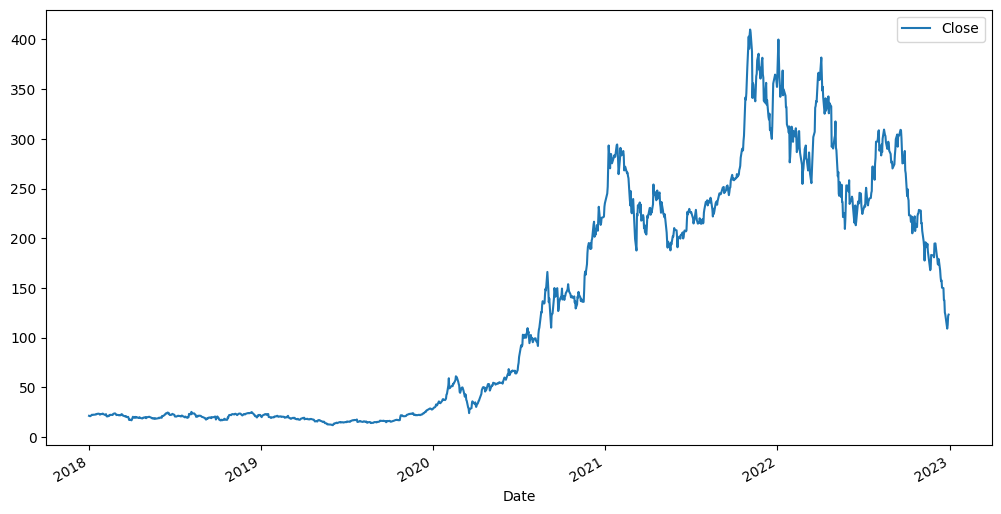

In [6]:
#그래프를 생성하여 정상성 판별
import matplotlib.pyplot as plt

df_tsla.plot(figsize = (12.2, 6.4))

#2018년부터 2022년까지의 긴 상승 추세와 2022년 이후 하락 추세가 보임
#상승과 하락을 반복하는 주기성이 약하게 나타남

In [7]:
#ADF 검정
#ADF(Augmented Dickey-Fuller) 검정: 대표적인 정상성 검증 기법
#p-값으로 정상성을 판단함
#데이터가 정상성을 띤다는 대립가설을 두고, p-값이 0.05이상일 때 가설을 기각하며 0.05이하이면 채택함

from statsmodels.tsa.stattools import adfuller #ADF 검정 라이브러리

print('ADF test with TSLA time-series')
ADF_result = adfuller(df_tsla.values)
#ADF 통계량
print('ADF Stats: %f' %ADF_result[0])
#p-값
print('p-value: %f' %ADF_result[1])
#임계값
print('Critical values: ')
for key, value in ADF_result[4].items():
  print('\t%s: %.4f' %(key, value))


#p-값 = 0.628680 > 0.05  -> 대립가설 기각. 데이터는 비정상성을 가진다.

ADF test with TSLA time-series
ADF Stats: -1.301076
p-value: 0.628680
Critical values: 
	1%: -3.4356
	5%: -2.8639
	10%: -2.5680


In [8]:
#KPSS(Kwiatkowski-Phillips-Schmidt-Shin)
#단위근(Unit-root)기반 검정 방법
#계절성에 민감한 통계량 분석에 유용
#다른 통계 검정과 반대로 귀무가설이 정상성, 대립가설이 비정상성

from statsmodels.tsa.stattools import kpss

print('KPSS test with TSLA time-series')
KPSS_result = kpss(df_tsla.values)
#KPSS 통계량
print('KPSS Stats: %f' %KPSS_result[0])
#p-값
print('p-value: %f' %KPSS_result[1])
#임계값
print('Critical values: ')
for key, value in KPSS_result[3].items():
  print('\t%s: %.4f' %(key, value))


#p-값이 0.05이하이므로, 데이터는 비정상성을 가진다.

KPSS test with TSLA time-series
KPSS Stats: 4.913280
p-value: 0.010000
Critical values: 
	10%: 0.3470
	5%: 0.4630
	2.5%: 0.5740
	1%: 0.7390


<ipython-input-8-d15c4cd6fcae>:9: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  KPSS_result = kpss(df_tsla.values)


In [9]:
# 월별 미국 비행기 탑승객 수 데이터

#pydataset의 데이터셋 확인
!pip install pydataset

from pydataset import data
data()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 44.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pydataset: filename=pydataset-0.2.0-py3-none-any.whl size=15939417 sha256=ce421afd5ab3c350bce490d26dcf869f7d1b8b0b226be9b018bb6103ec45ec17
  Stored in directory: /root/.cache/pip/wheels/2b/83/5c/073c3755e8b7704e4677557b2055e61026c1a2342149214c13
Successfully built pydataset
initiated datasets repo at: /root/.pydataset/


,dataset_id,title
0,AirPassengers,Monthly Airline Passenger Numbers 1949-1960
1,BJsales,Sales Data with Leading Indicator
2,BOD,Biochemical Oxygen Demand
3,Formaldehyde,Determination of Formaldehyde
4,HairEyeColor,Hair and Eye Color of Statistics Students
...,...,...
752,VerbAgg,Verbal Aggression item responses
753,cake,Breakage Angle of Chocolate Cakes
754,cbpp,Contagious bovine pleuropneumonia
755,grouseticks,Data on red grouse ticks from Elston et al. 2001


In [ ]:
#AirPassengers 데이터셋 로드
air = data('AirPassengers')
data('AirPassengers', show_doc = True)
#show_doc : 데이터셋 설명을 나타냄, 데이터셋의 출처와 대략적인 내용을 확인할 수 있음

In [16]:
air

,time,AirPassengers
1,1949.000000,112
2,1949.083333,118
3,1949.166667,132
4,1949.250000,129
5,1949.333333,121
6,1949.416667,135
7,1949.500000,148
8,1949.583333,148
9,1949.666667,136
10,1949.750000,119


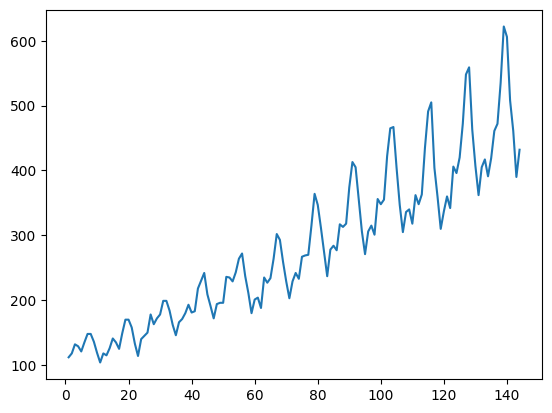

In [11]:
#그래프로 시계열 패턴 확인

import matplotlib.pyplot as plt

data = air['AirPassengers']
plt.plot(data)
plt.show()

# 증가와 감소를 반복하는 계절성 및 주기성 패턴이 나타남
# 주기마다 평균과 분산이 점차 증가하는 패턴이 있음
# 점차 증가하는 추세가 확인됨

In [12]:
#AirPassengers 데이터셋 ADF 검정

from statsmodels.tsa.stattools import adfuller

print('ADF test with AirPassengers time-series')
ADF_result = adfuller(data)
#ADF 통계량
print('ADF Stats: %f' %ADF_result[0])
#p-값
print('p-value: %f' %ADF_result[1])
#임계값
print('Critical values: ')
for key, value in ADF_result[4].items():
  print('\t%s: %.4f' %(key, value))

#p-값이 0.99f로, 0.05를 한참 초과함 -> AirPassengers 데이터셋은 비정상성 데이터이다.

ADF test with AirPassengers time-series
ADF Stats: 0.815369
p-value: 0.991880
Critical values: 
	1%: -3.4817
	5%: -2.8840
	10%: -2.5788


In [14]:
#AirPassengers 데이터셋 KPSS 검정

from statsmodels.tsa.stattools import kpss

print('KPSS test with AirPassengers time-series')
KPSS_result = kpss(data)
#KPSS 통계량
print('KPSS Stats: %f' %KPSS_result[0])
#p-값
print('p-value: %f' %KPSS_result[1])
#임계값
print('Critical values: ')
for key, value in KPSS_result[3].items():
  print('\t%s: %.4f' %(key, value))

#p-값은 0.01로 채택 수준인 0.05보다 한참 작음 -> AirPassengers 데이터셋은 비정상성을 가진 것으로 판단.

KPSS test with AirPassengers time-series
KPSS Stats: 1.651312
p-value: 0.010000
Critical values: 
	10%: 0.3470
	5%: 0.4630
	2.5%: 0.5740
	1%: 0.7390


<ipython-input-14-2d09bfbb2a1d>:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  KPSS_result = kpss(data)


In [ ]:
#데이터 정상성 확보
# - 분산 안정화(Variance stabilization)
# - 추세 제거(De-trend by differencing)
# - 계절성 제거(De-seasonality by differencing)

In [15]:
#분산 안정화 : 분산이 고정적이지 않을 때 데이터를 멱 변환(Power Transformation) 하는 방법
#로그 변환(Log transformation) : 분산이 점점 증가하는 데이터에 적용
#제곱근 변환(Root transformation) : 분산이 점점 감소하는 데이터에 적용

#로그 변환
import numpy as np

df_log_air = np.log(air['AirPassengers'])
df_log_air.head() #탑승객 수가 소수점을 포함한 10 이하의 숫자로 변환됨

1    4.718499
2    4.770685
3    4.882802
4    4.859812
5    4.795791
Name: AirPassengers, dtype: float64

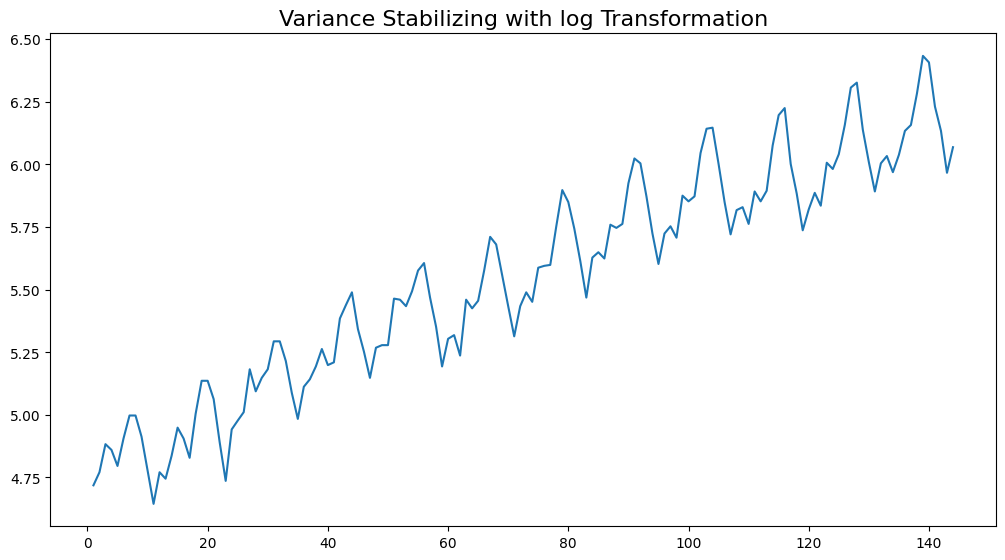

In [17]:
#분산 안정화 결과
df_log_air.plot(figsize = (12.2, 6.4))
plt.title('Variance Stabilizing with log Transformation', fontsize = 16)
plt.show()

#주기별 변동폭이 일정해짐

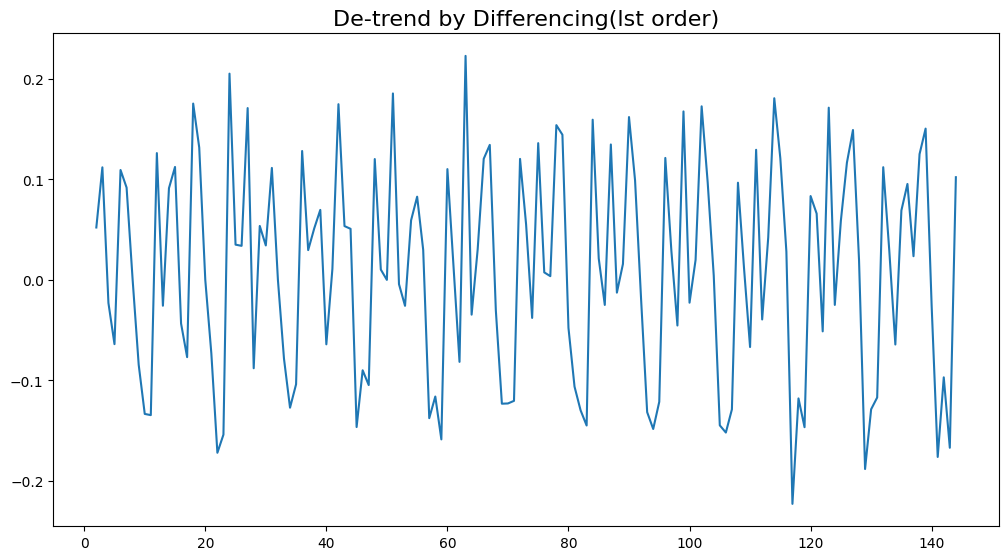

In [19]:
#차분과 추세 제거
# - 차분(Differencing): 현재 시점의 시계열 값에서 시간 t 이전의 값을 빼서 데이터를 값의 증감으로 변환하는 기법

#차분 변환으로 추세 제거

df_log_air_diff = df_log_air.diff(1).dropna() #차분 변환으로 생긴 모든 결측을 dropna()함수로 제거함
df_log_air_diff.plot(figsize=(12.2, 6.4))
plt.title('De-trend by Differencing(lst order)', fontsize = 16)
plt.show()

In [20]:
#차분 결과 ADF 검정
print('ADf test with AirPassengers time-series')
ADF_result_diff = adfuller(df_log_air_diff)

print('ADF Stats: %f' % ADF_result_diff[0])
print('p-value: %f' %ADF_result_diff[1])
print('Critical values: ')
for key, value in ADF_result_diff[4].items():
  print('\t%s: %.4f' %(key, value))

#p-값이 0.07로 0.05와 가깝게 되었음 -> 아직 다른 비정상성 패턴이 있음을 추측할 수 있음.

ADf test with AirPassengers time-series
ADF Stats: -2.717131
p-value: 0.071121
Critical values: 
	1%: -3.4825
	5%: -2.8844
	10%: -2.5790


In [21]:
ADF_result_diff

(-2.717130598388114,
 0.07112054815086184,
 14,
 128,
 {'1%': -3.4825006939887997,
  '5%': -2.884397984161377,
  '10%': -2.578960197753906},
 -440.35846985568105)

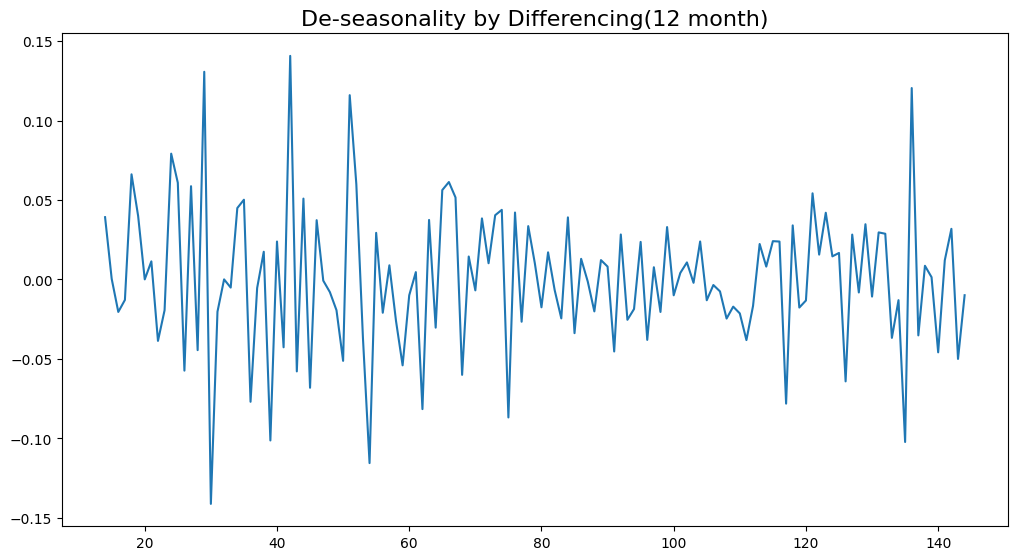

In [23]:
#차분과 계절성 제거
# - 추세 차분이 누적 증가나 감소의 영향을 줄이기 위해 현재 값에서 이전 값을 빼는 차분이라면,
#   계절 차분은 1년 중 12개 시점에서 각각 1년 전의 값을 빼는 차분이다. -> diff() 함수 인자를 차분 계수 12로 설정
# 차분이 12개씩 이루어지므로 최대 12개의 결측치가 생기며, 추세 차분과 마찬가지로 결측을 제거함

df_log_air_diff_season = df_log_air_diff.diff(12).dropna()

df_log_air_diff_season.plot(figsize = (12.2, 6.4))
plt.title('De-seasonality by Differencing(12 month)', fontsize = 16)
plt.show()


In [24]:
#최종 변환된 데이터 ADF, KPSS 검정
#ADF 검정
print('ADF test with AirPassengers time-series')
ADF_result_diff_season = adfuller(df_log_air_diff_season)

print('ADF Stats: %f' % ADF_result_diff_season[0])
print('p-value: %f' %ADF_result_diff_season[1])
print('Critical values: ')
for key, value in ADF_result_diff_season[4].items():
  print('\t%s: %.4f' %(key, value))

print('KPSS test with AirPassengers time-series')
KPSS_result_diff_season = kpss(df_log_air_diff_season)
print('KPSS Stats: %f' %KPSS_result_diff_season[0])
print('p-value: %f' %KPSS_result_diff_season[1])
print('Critical values: ')
for key, value in KPSS_result_diff_season[3].items():
  print('\t%s: %.4f' %(key, value))

#ADF 검정 결과 : p-값이 0.000249로 0.05보다 아주 작은 값
#KPSS 검정 결과는 p-값이 0.1로 유의수준보다 큼 -> 시계열 예측에 적절한 데이터로 변환됨.

ADF test with AirPassengers time-series
ADF Stats: -4.443325
p-value: 0.000249
Critical values: 
	1%: -3.4870
	5%: -2.8864
	10%: -2.5800
KPSS test with AirPassengers time-series
KPSS Stats: 0.073191
p-value: 0.100000
Critical values: 
	10%: 0.3470
	5%: 0.4630
	2.5%: 0.5740
	1%: 0.7390


<ipython-input-24-e302f7468e99>:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  KPSS_result_diff_season = kpss(df_log_air_diff_season)


In [ ]:
# 통계 기반 예측 -> ARIMA
# ARIMA : 자기회귀 모형과 이동평균 모형을 결합한 모형
# 자기회귀(AR) 모형 : 데이터의 과거 값들을 선형으로 조합하여 미래 값을 예측하는 모형. 과거의 값 전부가 현재의 값에 영향을 미침.
# 이동평균(MA) 모형 : 데이터가 어떤 방향성을 가지고 증가하거나 감소할 때, 즉 데이터가 이동할 때마다 평균을 구하여 예측에 활용하는 모형
# ARMA 모형 : AR 모형과 MA 모형을 결합한 모형. 현재에서 과거 특정 시점까지의 데이터 전부에다가 증가 또는 감소 추세까지 전부 반영하여 예측함
# AR, MA, ARMA 모형은 모두 정상성 시계열 데이터를 전제로 사용 가능함. 데이터를 차분하거나 변환하여 정상성을 확보한 후에 학습 및 예측을 진행함.

#ARIMA : AR과 MA가 결합한 점은 ARMA와 동일하지만 비정상성 데이터를 차분하여 예측하도록 지원함. 사전에 데이터 변환 또는 차분을 수행할 필요는 없으며,
#        차분 계수 또는 변환 방법을 입력하기만 하면 됨

In [80]:
#ARIMA 모형을 이용하는 예측

#테슬라 주가 데이터

import pandas as pd
import yfinance as yf

tsla = yf.download('TSLA', start = '2022-11-01', end='2024-03-31')
df_tsla = pd.DataFrame(tsla['Close'])
df_tsla.head()

[*********************100%%**********************]  1 of 1 completed


,Close
Date,
2022-11-01,227.820007
2022-11-02,214.979996
2022-11-03,215.309998
2022-11-04,207.470001
2022-11-07,197.080002


In [81]:
#인덱스 가공

df_tsla = df_tsla.reset_index()
df_tsla.columns = ['date', 'value']
df_tsla['date'] = pd.to_datetime(df_tsla['date'])
df_tsla

,date,value
0,2022-11-01,227.820007
1,2022-11-02,214.979996
2,2022-11-03,215.309998
3,2022-11-04,207.470001
4,2022-11-07,197.080002
...,...,...
266,2023-11-22,234.210007
267,2023-11-24,235.449997
268,2023-11-27,236.080002
269,2023-11-28,246.720001


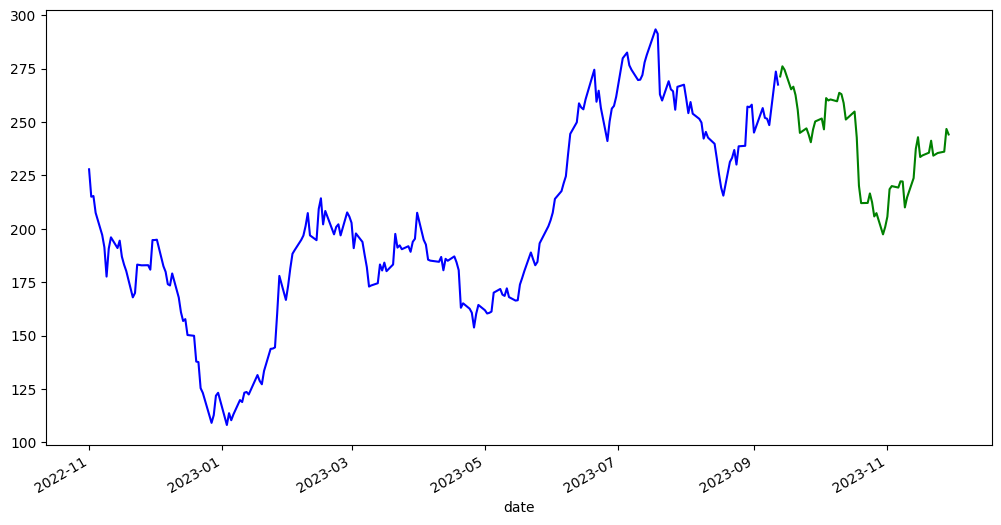

In [82]:
#학습 데이터와 테스트 데이터 분할

import matplotlib.pyplot as plt

#데이터 분할하기
df_tsla_train = pd.DataFrame(df_tsla['value'][:int(0.8*len(df_tsla))])
df_tsla_test = pd.DataFrame(df_tsla['value'][int(0.8*len(df_tsla)):])
df_tsla_train['date'] = df_tsla['date'][:int(0.8*len(df_tsla))]
df_tsla_test['date'] = df_tsla['date'][int(0.8*len(df_tsla)):]
df_tsla_train.set_index('date', inplace = True)
df_tsla_test.set_index('date', inplace = True)

df_tsla_train['value'].plot(figsize=(12.2, 6.4), color='blue')
df_tsla_test['value'].plot(color='green')
plt.show()

In [83]:
#차분 횟수 확인

!pip install pmdarima

from pmdarima.arima import ndiffs, nsdiffs # ARIMA 모형에 적용할 최적의 차분 횟수를 찾아줌
print(f"최적의 차분 횟수 (ADF): {ndiffs(df_tsla_train, test='adf')}")
print(f"최적의 차분 횟수 (KPSS): {ndiffs(df_tsla_train, test='kpss')}")
print(f"최적의 차분 횟수 (PP): {ndiffs(df_tsla_train, test='pp')}")

최적의 차분 횟수 (ADF): 1
최적의 차분 횟수 (KPSS): 1
최적의 차분 횟수 (PP): 1


In [84]:
#계절성 확인
print(f"최적의 차분 계수 (OCSB): {nsdiffs(df_tsla_train, m = 12, test='ocsb')}")
print(f"최적의 차분 계수 (CH): {nsdiffs(df_tsla_train, m = 12, test='ch')}")

#차분 계수가 0 -> 계절성이 없음.

최적의 차분 계수 (OCSB): 0
최적의 차분 계수 (CH): 0


In [85]:
#ARIMA 모형 탐색

from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

n_diffs = 1
model_fit = pm.auto_arima(
            y = df_tsla_train['value'],
            d = n_diffs,
            start_p = 0, max_p = 2,
            start_q = 0, max_q = 2,
            m = 1, seasonal=False,
            stepwise = True,
            trace = True)
print(model_fit.summary())

#ARIMA(0,1,0) 모형이 주어진 데이터와 가장 적합한 모형으로 판별됨.

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1478.567, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1480.511, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1480.514, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1476.698, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1478.977, Time=0.16 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.327 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  216
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -737.349
Date:                Thu, 30 Nov 2023   AIC                           1476.698
Time:                        05:41:21   BIC                           1480.069
Sample:                             0   HQIC                          1478.060
                                - 216                                       

In [86]:
#최적 ARIMA 모형으로 예측
tsla_pred = model_fit.predict(n_periods = len(df_tsla_test))
df_tsla_pred = pd.DataFrame(tsla_pred)

result = pd.DataFrame(df_tsla_test['value'].values,\
                      index = df_tsla_test.index, columns=['value'])
result

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,value
date,
2023-09-13,271.299988
2023-09-14,276.040009
2023-09-15,274.390015
2023-09-18,265.279999
2023-09-19,266.500000
2023-09-20,262.589996
2023-09-21,255.699997
2023-09-22,244.880005
2023-09-25,246.990005


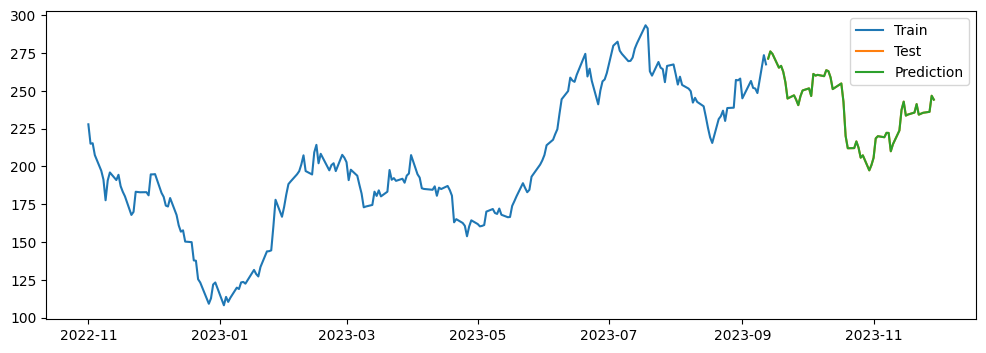

In [87]:
#예측 주가 시각화

fig, axes = plt.subplots(1,1, figsize = (12, 4))

plt.plot(df_tsla_train, label = 'Train') # 훈련 데이터
plt.plot(df_tsla_test, label = 'Test') # 테스트 데이터
plt.plot(result, label = 'Prediction') # 예측 데이터

plt.legend()
plt.show()

In [88]:
#주가를 하루씩 예측

def each_step_prediction():
  pred_next = model_fit.predict(n_periods = 1)
  return pred_next.tolist()[0]

pred_steps = []
for new_inst in df_tsla_test['value']:
  pred = each_step_prediction()
  pred_steps.append(pred)
  model_fit.update(new_inst)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


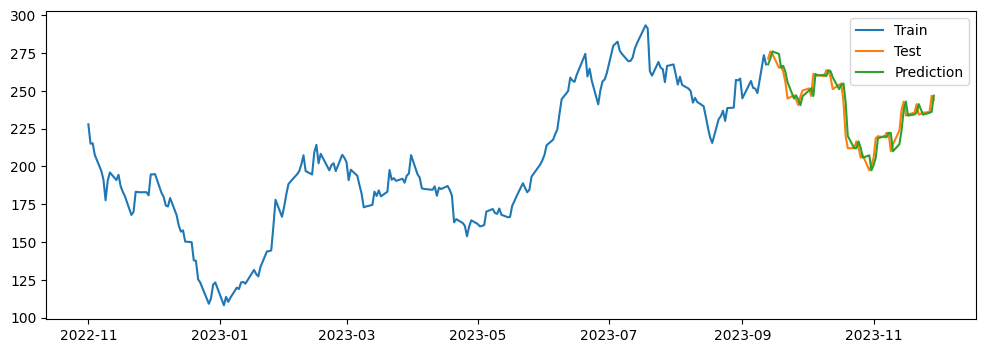

In [90]:
#하루에 예측한 주가 시각화

fig, axes = plt.subplots(1,1, figsize = (12, 4))

plt.plot(df_tsla_train.index, df_tsla_train['value'], label = 'Train')
plt.plot(df_tsla_test.index, df_tsla_test['value'], label = 'Test')
plt.plot(df_tsla_test.index, pred_steps, label = 'Prediction')

plt.legend()
plt.show()

In [ ]:
#인공신경망을 활용한 주가 예측
#RNN(Recurrent Neural Network, 순환신경망)
# - 현재 단계의 결과를 다음 단계의 입력으로 순차적(Sequentially) 전달한다.
# - 신경망 내부는 데이터의 시변적 특성을 저장하도록 구성됨.
# - LSTM(Long short-term memory)
# - one to one, one to many, mant to one, many to many, many to many

In [92]:
# many to one 의 RNN을 활용하는 예측

#테슬라 주가 데이터 로드

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

tsla = yf.download('TSLA', start = '2022-11-01', end = '2024-03-31')
df_tsla = pd.DataFrame(tsla['Close'])

df_tsla = df_tsla.reset_index()
df_tsla.columns = ['date', 'value']
df_tsla['date'] = pd.to_datetime(df_tsla['date'])
df_tsla.set_index('date', inplace = True)

[*********************100%%**********************]  1 of 1 completed


In [95]:
#테스트 데이터 분할 및 데이터 스케일링

df_tsla.reset_index()
dataset_tsla = df_tsla.values

#데이터 분할하기
df_tsla_train = dataset_tsla[:int(0.8*len(dataset_tsla)), :]
df_tsla_test = dataset_tsla[int(0.8*len(dataset_tsla)):, :]

#데이터 스케일링하기
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(dataset_tsla)

In [97]:
#학습 데이터 가공

x_train_data, y_train_data=[], []

#28을 기준으로 데이터 생성하기
for i in range(28, len(df_tsla_train)):
  x_train_data.append(scaled_data[i-28:i, 0])
  y_train_data.append(scaled_data[i, 0])

x_train_data, y_train_data = np.array(x_train_data), np.array(y_train_data)
x_train_data = np.reshape(x_train_data, (x_train_data.shape[0],\
                                         x_train_data.shape[1],1))

In [99]:
#RNN 모형 설계 및 파라미터 정의

lstm_tsla = Sequential()
lstm_tsla.add(LSTM(units = 28, return_sequences = True,\
                   input_shape = (x_train_data.shape[1], 1)))
lstm_tsla.add(LSTM(units = 28))
lstm_tsla.add(Dense(1))

#데이터 재가공하기
inputs_data = df_tsla[len(df_tsla) - len(df_tsla_test)-28:].values
inputs_data = inputs_data.reshape(-1, 1)
inputs_data = scaler.transform(inputs_data)

#모형의 학습 방법 설정하여 학습 진해하기
lstm_tsla.compile(loss = 'mean_squared_error', optimizer = 'adam')
lstm_tsla.fit(x_train_data, y_train_data, epochs = 100, batch_size = 1, verbose = 2)

Epoch 1/100
188/188 - 5s - loss: 0.0274 - 5s/epoch - 29ms/step
Epoch 2/100
188/188 - 2s - loss: 0.0087 - 2s/epoch - 10ms/step
Epoch 3/100
188/188 - 2s - loss: 0.0061 - 2s/epoch - 9ms/step
Epoch 4/100
188/188 - 3s - loss: 0.0045 - 3s/epoch - 15ms/step
Epoch 5/100
188/188 - 2s - loss: 0.0048 - 2s/epoch - 13ms/step
Epoch 6/100
188/188 - 2s - loss: 0.0038 - 2s/epoch - 10ms/step
Epoch 7/100
188/188 - 2s - loss: 0.0031 - 2s/epoch - 9ms/step
Epoch 8/100
188/188 - 2s - loss: 0.0035 - 2s/epoch - 10ms/step
Epoch 9/100
188/188 - 2s - loss: 0.0036 - 2s/epoch - 9ms/step
Epoch 10/100
188/188 - 3s - loss: 0.0038 - 3s/epoch - 17ms/step
Epoch 11/100
188/188 - 3s - loss: 0.0029 - 3s/epoch - 16ms/step
Epoch 12/100
188/188 - 2s - loss: 0.0029 - 2s/epoch - 10ms/step
Epoch 13/100
188/188 - 2s - loss: 0.0031 - 2s/epoch - 9ms/step
Epoch 14/100
188/188 - 2s - loss: 0.0027 - 2s/epoch - 9ms/step
Epoch 15/100
188/188 - 2s - loss: 0.0033 - 2s/epoch - 10ms/step
Epoch 16/100
188/188 - 2s - loss: 0.0028 - 2s/epoch - 

In [122]:
#학습이 완료된 RNN 모형으로 주가 예측
X_test = []
for i in range(28, inputs_data.shape[0]):
  X_test.append(inputs_data[i-28:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_value = lstm_tsla.predict(X_test)
predicted_value = scaler.inverse_transform(predicted_value)

predicted_value.shape

2/2 [==============================] - 0s 14ms/step


(55, 1)

<ipython-input-123-264be7c0cfdf>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tsla_test_vis['Predictions'] = predicted_value


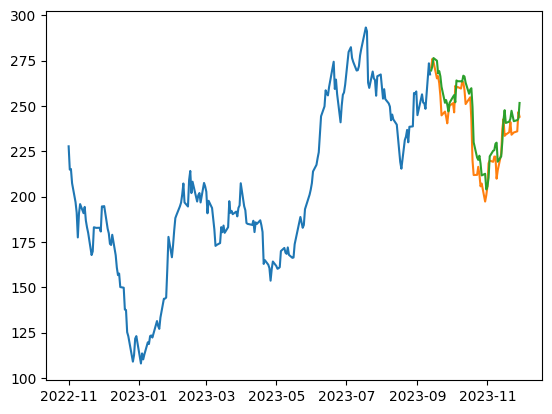

In [123]:
#주가 예측 결과 시각화
df_tsla_train_vis = tsla[:216]
df_tsla_test_vis = tsla[216:]

df_tsla_test_vis['Predictions'] = predicted_value
plt.plot(df_tsla_train_vis['Close'])
plt.plot(df_tsla_test_vis[['Close', 'Predictions']])